# End-to-end Masked Language Modeling with BERT

**Author:** [Ankur Singh](https://twitter.com/ankur310794)<br>
**Date created:** 2020/09/18<br>
**Last modified:** 2024/03/15<br>
**Description:** Implement a Masked Language Model (MLM) with BERT and fine-tune it on the IMDB Reviews dataset.

---

EQUIPE:

* Ana Carolina Aguiar - Mat.: 20210024326
* Cassiano Sabino - Mat.: 20210025806
* Geovana Lima - Mat.: 20210024729

---

## Introduction

Masked Language Modeling is a fill-in-the-blank task,
where a model uses the context words surrounding a mask token to try to predict what the
masked word should be.

For an input that contains one or more mask tokens,
the model will generate the most likely substitution for each.

Example:

- Input: "I have watched this [MASK] and it was awesome."
- Output: "I have watched this movie and it was awesome."

Masked language modeling is a great way to train a language
model in a self-supervised setting (without human-annotated labels).
Such a model can then be fine-tuned to accomplish various supervised
NLP tasks.

This example teaches you how to build a BERT model from scratch,
train it with the masked language modeling task,
and then fine-tune this model on a sentiment classification task.

We will use the Keras `TextVectorization` and `MultiHeadAttention` layers
to create a BERT Transformer-Encoder network architecture.

Note: This example should be run with `tf-nightly`.

---

EQUIPE:

⇒ Para o nosso projeto, construímos um modelo BERT do zero, treinamos com Masked Language Modeling (MLM) e realizamos o fine-tuning em uma tarefa de classificação hierárquica de artigos da Wikipédia com base no dataset [DBpedia](https://www.kaggle.com/datasets/danofer/dbpedia-classes?select=DBP_wiki_data.csv).

---

## Setup

Install `tf-nightly` via `pip install tf-nightly`.

---

EQUIPE:

⇒ Mantivemos o mesmo setup do notebook original.

---

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # or jax, or tensorflow

import keras_hub

import keras
from keras import layers
from keras.layers import TextVectorization

from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

2025-04-16 12:29:58.720380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744817398.847372    2782 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744817398.871770    2782 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-16 12:29:59.143856: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set-up Configuration

In [6]:

@dataclass
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 30000
    EMBED_DIM = 128
    NUM_HEAD = 8  # used in bert model
    FF_DIM = 128  # used in bert model
    NUM_LAYERS = 1


config = Config()

## Load the data

In [7]:
train_df : pd.DataFrame = pd.read_csv("../dbpedia-classes/DBPEDIA_train.csv")
test_df : pd.DataFrame = pd.read_csv("../dbpedia-classes/DBPEDIA_test.csv")

---

EQUIPE:

⇒ Não é necessário fazer o drop das outras colunas, já que vamos usar as três classes para classificação.

---

In [8]:
train_df.head()

,text,l1,l2,l3
0,"William Alexander Massey (October 7, 1856 – Ma...",Agent,Politician,Senator
1,Lions is the sixth studio album by American ro...,Work,MusicalWork,Album
2,"Pirqa (Aymara and Quechua for wall, hispaniciz...",Place,NaturalPlace,Mountain
3,Cancer Prevention Research is a biweekly peer-...,Work,PeriodicalLiterature,AcademicJournal
4,The Princeton University Chapel is located on ...,Place,Building,HistoricBuilding


---

EQUIPE:

⇒ Não é necessário mais renomear as labels, já que usaremos as três.

---

In [9]:
all_data = pd.concat([train_df, test_df], ignore_index=True)

## Dataset preparation

We will use the `TextVectorization` layer to vectorize the text into integer token ids.
It transforms a batch of strings into either
a sequence of token indices (one sample = 1D array of integer token indices, in order)
or a dense representation (one sample = 1D array of float values encoding an unordered set of tokens).

Below, we define 3 preprocessing functions.

1.  The `get_vectorize_layer` function builds the `TextVectorization` layer.
2.  The `encode` function encodes raw text into integer token ids.
3.  The `get_masked_input_and_labels` function will mask input token ids.
It masks 15% of all input tokens in each sequence at random.



---


EQUIPE:

⇒ Utilizamos as mesmas funções de pré-processamento para preparar os textos do dataset para serem:

* Codificados como sequências de inteiros (tokens).
* Mascarados parcialmente para treinar o modelo com MLM.
* Organizados em conjuntos de treino/teste para classificação supervisionada.

⇒ Do BERT:
* 15% dos tokens são escolhidos para mascaramento.
* Dos tokens escolhidos:
    - 80% viram `[MASK]`
    - 10% viram tokens aleatórios
    - 10% permanecem inalterados

Isso ajuda o modelo a aprender contexto, não apenas prever `[MASK]`.

---





---


EQUIPE:

⇒ Utilizaremos o mesmo peso do BERT criado anteriormente, já que ele já vai estar adaptado a distribuição desse dataset.

⇒ Foram construídos os seguintes datasets:
* `train_classifier_ds`: textos vetorizados + rótulos para treino
* `test_classifier_ds`: textos vetorizados + rótulos para teste
* `mlm_ds`: textos com tokens mascarados, rótulos verdadeiros e pesos de amostra


---



In [10]:
# For data pre-processing and tf.data.Dataset
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder


def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
    )


def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):
    """Build Text vectorization layer

    Args:
      texts (list): List of string i.e input texts
      vocab_size (int): vocab size
      max_seq (int): Maximum sequence length.
      special_tokens (list, optional): List of special tokens. Defaults to ['[MASK]'].

    Returns:
        layers.Layer: Return TextVectorization Keras Layer
    """
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    vectorize_layer.adapt(texts)

    # Insert mask token in vocabulary
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"] # Why is this hardcoded????
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer


vectorize_layer = get_vectorize_layer(
    all_data.text.values.tolist(),
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[mask]"],
)

# Get mask token id for masked language model
mask_token_id = vectorize_layer(["[mask]"]).cpu().numpy()[0][0]


def encode(texts):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.cpu().numpy()


label_encoder_l1 = LabelEncoder()
label_encoder_l2 = LabelEncoder()
label_encoder_l3 = LabelEncoder()

# We have 25000 examples for training
# Equipe => O Y deixou de ser apenas uma coluna e se tornou um DF com as três labels
x_train = encode(train_df.text.values)  # encode reviews with vectorizer

y_train = pd.DataFrame([train_df.l1.values, train_df.l2.values, train_df.l3.values])

y_train_encoded = pd.DataFrame()
y_train_encoded["l1"] = label_encoder_l1.fit_transform(train_df['l1'].values).astype(float)
y_train_encoded["l2"] = label_encoder_l2.fit_transform(train_df['l2'].values).astype(float)
y_train_encoded["l3"] = label_encoder_l3.fit_transform(train_df['l3'].values).astype(float)

y_train_l1 = y_train_encoded["l1"].to_numpy()
y_train_l2 = y_train_encoded["l2"].to_numpy()
y_train_l3 = y_train_encoded["l3"].to_numpy()

# We have 25000 examples for testing
x_test = encode(test_df.text.values)
y_test = pd.DataFrame([test_df.l1.values, test_df.l2.values, test_df.l3.values])

# Transforma os rótulos do teste (usando o mesmo codificador)
y_test_encoded = pd.DataFrame()
y_test_encoded["l1"] = label_encoder_l1.transform(test_df['l1'].values).astype(float)
y_test_encoded["l2"] = label_encoder_l2.transform(test_df['l2'].values).astype(float)
y_test_encoded["l3"] = label_encoder_l3.transform(test_df['l3'].values).astype(float)

y_test_l1 = y_test_encoded["l1"].to_numpy()
y_test_l2 = y_test_encoded["l2"].to_numpy()
y_test_l3 = y_test_encoded["l3"].to_numpy()


train_classifier_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, {"l1": y_train_l1, "l2": y_train_l2, "l3": y_train_l3}))
    .shuffle(1000)
    .batch(config.BATCH_SIZE)
)

test_classifier_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, {"l1": y_test_l1, "l2": y_test_l2, "l3": y_test_l3}))
    .batch(config.BATCH_SIZE)
)
# Dataset for end to end model input (will be used at the end)
test_raw_classifier_ds = test_df

<>:10: SyntaxWarning: invalid escape sequence '\^'
<>:10: SyntaxWarning: invalid escape sequence '\^'
/tmp/ipykernel_2782/3142237899.py:10: SyntaxWarning: invalid escape sequence '\^'
  stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
2025-04-16 12:33:57.595404: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 495638432 exceeds 10% of free system memory.
2025-04-16 12:33:57.595488: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 743457648 exceeds 10% of free system memory.


Instructions for updating:
Use tf.identity with explicit device placement instead.


2025-04-16 12:34:48.535662: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 395784320 exceeds 10% of free system memory.
2025-04-16 12:34:48.537231: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 593676480 exceeds 10% of free system memory.
2025-04-16 12:34:50.852936: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 493449216 exceeds 10% of free system memory.


## Create BERT model (Pretraining Model) for masked language modeling

We will create a BERT-like pretraining model architecture
using the `MultiHeadAttention` layer.
It will take token ids as inputs (including masked tokens)
and it will predict the correct ids for the masked input tokens.

---

EQUIPE:

⇒ A função `bert_module` implementa um bloco codificador (encoder) da arquitetura Transformer. Cada encoder contém:

* Multi-Head Self Attention: o modelo aprende a prestar atenção em diferentes partes da sequência.
* Skip Connection + Normalização: adiciona o residual (skip-connection) e normaliza. Ajuda no fluxo de gradiente.
* Feed-forward (FFN): rede neural simples para transformar as representações.
* Skip Connection + Normalização novamente.

⇒ A `MaskedLanguageModel` é uma subclasse do `keras.Model` que calcula a loss de classificação por token mascarado (SparseCategoricalCrossentropy), reporta a loss média, e garante que o Keras possa resetar o estado da métrica automaticamente.

⇒ Já a função `create_masked_language_bert_model()` monta o modelo inteiro com
input layer (tokens inteiros de tamanho fixo) e embedding de palavras + posições e blocos `bert_module`.

⇒ No `MaskedTextGenerator` está o callback para acompanhar o desempenho do modelo após cada época.

---

In [8]:

def bert_module(query, key, value, i):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}_multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}_att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}_ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}_ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


loss_fn = keras.losses.SparseCategoricalCrossentropy(reduction=None)
loss_tracker = keras.metrics.Mean(name="loss")


class MaskedLanguageModel(keras.Model):

    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):

        loss = loss_fn(y, y_pred, sample_weight)
        loss_tracker.update_state(loss, sample_weight=sample_weight)
        return keras.ops.sum(loss)

    def compute_metrics(self, x, y, y_pred, sample_weight):

        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker]


def create_masked_language_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")

    word_embeddings = layers.Embedding(
        config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding"
    )(inputs)
    position_embeddings = keras_hub.layers.PositionEmbedding(
        sequence_length=config.MAX_LEN
    )(word_embeddings)
    embeddings = word_embeddings + position_embeddings

    # TODO: Discover what the fuck this do
    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)

    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(
        encoder_output
    )
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model


id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}


class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens)

        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(sample_tokens[0].cpu().numpy()),
                "prediction": self.decode(tokens),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            pprint(result)

sample_tokens = vectorize_layer(["The [mask] of the article is unknown."])
bert_masked_model = create_masked_language_bert_model()
bert_masked_model.summary()

Model: "masked_bert_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_embedding      │ (None, 256, 128)  │  3,840,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, 256, 128)  │     32,768 │ word_embedding[0… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 128)  │          0 │ word_embedding[0… │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_multihea… │ (None, 256, 128)  │     66,048 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0],        │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_drop… │ (None, 256, 128)  │          0 │ encoder_0_multih… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 128)  │          0 │ add[0][0],        │
│                     │                   │            │ encoder_0_att_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_laye… │ (None, 256, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn       │ (None, 256, 128)  │     33,024 │ encoder_0_att_la… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_drop… │ (None, 256, 128)  │          0 │ encoder_0_ffn[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256, 128)  │          0 │ encoder_0_att_la… │
│                     │                   │            │ encoder_0_ffn_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_laye… │ (None, 256, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlm_cls (Dense)     │ (None, 256,       │  3,870,000 │ encoder_0_ffn_la… │
│                     │ 30000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,842,352 (29.92 MB)

 Trainable params: 7,842,352 (29.92 MB)

 Non-trainable params: 0 (0.00 B)

## Fine-tune a sentiment classification model

We will fine-tune our self-supervised model on a downstream task of sentiment classification.
To do this, let's create a classifier by adding a pooling layer and a `Dense` layer on top of the
pretrained BERT features.

---

EQUIPE:

⇒ Aqui, estamos carregando um modelo BERT treinado com Masked Language Modeling (MLM) e usando sua saída como base (congelada) para um classificador. Então, adicionamos camadas extras para transformar embeddings do BERT em previsões de classes, treinando primeiro só o classificador, com o BERT congelado, depois, liberando o BERT para fine-tuning, e continuando o treinamento.

---

In [ ]:
# Load pretrained bert model
mlm_model = keras.models.load_model(
    "./L3/bert_mlm_dbpedia-l3.keras", custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)
pretrained_bert_model = keras.Model(
    mlm_model.input, mlm_model.get_layer("encoder_0_ffn_layernormalization").output
)

# Freeze it
pretrained_bert_model.trainable = False


def create_classifier_bert_model():
    inputs = layers.Input((config.MAX_LEN, ), dtype="int64")

    sequence_output = pretrained_bert_model(inputs)
    pooled_output = layers.GlobalMaxPooling1D()(sequence_output)
    hidden_layer = layers.Dense(64, activation="relu")(pooled_output)

    num_classes_l1 = len(label_encoder_l1.classes_)
    num_classes_l2 = len(label_encoder_l2.classes_)
    num_classes_l3 = len(label_encoder_l3.classes_)
    output_l1 = layers.Dense(num_classes_l1, activation="softmax", name="l1")(hidden_layer)
    output_l2 = layers.Dense(num_classes_l2, activation="softmax", name="l2")(hidden_layer)
    output_l3 = layers.Dense(num_classes_l3, activation="softmax", name="l3")(hidden_layer)

    classifer_model = keras.Model(inputs, [output_l1, output_l2, output_l3], name="classification")
    optimizer = keras.optimizers.Adam()
    classifer_model.compile(
      optimizer=optimizer,
      loss={
            "l1": "sparse_categorical_crossentropy",
            "l2": "sparse_categorical_crossentropy",
            "l3": "sparse_categorical_crossentropy",
        },
        metrics={
            "l1": "accuracy",
            "l2": "accuracy",
            "l3": "accuracy",
        }
    )
    return classifer_model


classifer_model = create_classifier_bert_model()
classifer_model.summary()

# Train the classifier with frozen BERT stage
classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

# Unfreeze the BERT model for fine-tuning
pretrained_bert_model.trainable = True
optimizer = keras.optimizers.Adam()
classifer_model.compile(
    optimizer=optimizer,
    loss={
        "l1": "sparse_categorical_crossentropy",
        "l2": "sparse_categorical_crossentropy",
        "l3": "sparse_categorical_crossentropy",
    },
    metrics={
        "l1": "accuracy",
        "l2": "accuracy",
        "l3": "accuracy",
    }
)
history = classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

Model: "classification"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 256, 128)  │  3,972,352 │ input_layer_2[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ functional_3[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1 (Dense)          │ (None, 9)         │        585 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l2 (Dense)          │ (None, 70)        │      4,550 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l3 (Dense)          │ (None, 219)       │     14,235 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,999,978 (15.26 MB)

 Trainable params: 27,626 (107.91 KB)

 Non-trainable params: 3,972,352 (15.15 MB)

Epoch 1/5


I0000 00:00:1744426316.830336   32641 service.cc:148] XLA service 0x55ca3b24ba70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744426316.831270   32641 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-04-11 23:51:56.983237: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744426317.479441   32641 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-04-11 23:51:58.691245: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 196 bytes spill stores, 196 bytes spill loads

2025-04-11 23:52:01.790581: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 

   8/7530 ━━━━━━━━━━━━━━━━━━━━ 1:55 15ms/step - l1_accuracy: 0.1646 - l1_loss: 4.6414 - l2_accuracy: 0.0075 - l2_loss: 6.4308 - l3_accuracy: 0.0078 - l3_loss: 6.7069 - loss: 17.7791              

I0000 00:00:1744426328.474090   32641 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7526/7530 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - l1_accuracy: 0.7691 - l1_loss: 0.6859 - l2_accuracy: 0.4792 - l2_loss: 1.9727 - l3_accuracy: 0.3243 - l3_loss: 3.0939 - loss: 5.7525

2025-04-11 23:53:20.262725: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 196 bytes spill stores, 196 bytes spill loads

2025-04-11 23:53:21.684411: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 24 bytes spill stores, 24 bytes spill loads



7530/7530 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l1_accuracy: 0.7691 - l1_loss: 0.6858 - l2_accuracy: 0.4793 - l2_loss: 1.9724 - l3_accuracy: 0.3243 - l3_loss: 3.0934 - loss: 5.7515

2025-04-11 23:53:43.937050: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11', 196 bytes spill stores, 196 bytes spill loads

2025-04-11 23:53:46.350419: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 624 bytes spill stores, 576 bytes spill loads

2025-04-11 23:53:48.503328: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 8 bytes spill stores, 8 bytes spill loads

2025-04-11 23:53:48.725121: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 24 bytes spill stores, 24 bytes spill loads



7530/7530 ━━━━━━━━━━━━━━━━━━━━ 118s 14ms/step - l1_accuracy: 0.7691 - l1_loss: 0.6858 - l2_accuracy: 0.4793 - l2_loss: 1.9723 - l3_accuracy: 0.3244 - l3_loss: 3.0933 - loss: 5.7513 - val_l1_accuracy: 0.8730 - val_l1_loss: 0.3526 - val_l2_accuracy: 0.7112 - val_l2_loss: 0.8984 - val_l3_accuracy: 0.6206 - val_l3_loss: 1.3220 - val_loss: 2.5730
Epoch 2/5
7530/7530 ━━━━━━━━━━━━━━━━━━━━ 115s 12ms/step - l1_accuracy: 0.8674 - l1_loss: 0.3616 - l2_accuracy: 0.7247 - l2_loss: 0.8583 - l3_accuracy: 0.6346 - l3_loss: 1.2658 - loss: 2.4857 - val_l1_accuracy: 0.8772 - val_l1_loss: 0.3405 - val_l2_accuracy: 0.7467 - val_l2_loss: 0.7812 - val_l3_accuracy: 0.6739 - val_l3_loss: 1.1043 - val_loss: 2.2260
Epoch 3/5
7530/7530 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - l1_accuracy: 0.8723 - l1_loss: 0.3470 - l2_accuracy: 0.7448 - l2_loss: 0.7939 - l3_accuracy: 0.6655 - l3_loss: 1.1393 - loss: 2.2802 - val_l1_accuracy: 0.8835 - val_l1_loss: 0.3212 - val_l2_accuracy: 0.7534 - val_l2_loss: 0.7544 - val_l3_accurac

2025-04-12 00:01:02.193735: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 388 bytes spill stores, 356 bytes spill loads

2025-04-12 00:01:03.873610: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 388 bytes spill stores, 356 bytes spill loads

2025-04-12 00:01:07.488843: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 220 bytes spill stores, 216 bytes spill loads

2025-04-12 00:01:11.882833: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 940 bytes spill stores, 872 bytes spill loads

2025-04-12 00:01:13.534690: I external/local_xla/xla/stream_e

7527/7530 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - l1_accuracy: 0.9749 - l1_loss: 0.0800 - l2_accuracy: 0.9274 - l2_loss: 0.2382 - l3_accuracy: 0.8905 - l3_loss: 0.3847 - loss: 0.7029

2025-04-12 00:03:53.482617: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3415_0', 132 bytes spill stores, 132 bytes spill loads

2025-04-12 00:03:55.491297: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3556_0', 132 bytes spill stores, 132 bytes spill loads



7530/7530 ━━━━━━━━━━━━━━━━━━━━ 201s 23ms/step - l1_accuracy: 0.9749 - l1_loss: 0.0800 - l2_accuracy: 0.9274 - l2_loss: 0.2381 - l3_accuracy: 0.8905 - l3_loss: 0.3846 - loss: 0.7028 - val_l1_accuracy: 0.9900 - val_l1_loss: 0.0339 - val_l2_accuracy: 0.9592 - val_l2_loss: 0.1357 - val_l3_accuracy: 0.9332 - val_l3_loss: 0.2426 - val_loss: 0.4122
Epoch 2/5
7530/7530 ━━━━━━━━━━━━━━━━━━━━ 152s 20ms/step - l1_accuracy: 0.9914 - l1_loss: 0.0282 - l2_accuracy: 0.9663 - l2_loss: 0.1079 - l3_accuracy: 0.9438 - l3_loss: 0.1954 - loss: 0.3315 - val_l1_accuracy: 0.9864 - val_l1_loss: 0.0448 - val_l2_accuracy: 0.9576 - val_l2_loss: 0.1457 - val_l3_accuracy: 0.9333 - val_l3_loss: 0.2463 - val_loss: 0.4368
Epoch 3/5
7530/7530 ━━━━━━━━━━━━━━━━━━━━ 153s 20ms/step - l1_accuracy: 0.9946 - l1_loss: 0.0175 - l2_accuracy: 0.9770 - l2_loss: 0.0719 - l3_accuracy: 0.9600 - l3_loss: 0.1347 - loss: 0.2241 - val_l1_accuracy: 0.9886 - val_l1_loss: 0.0410 - val_l2_accuracy: 0.9577 - val_l2_loss: 0.1500 - val_l3_accura

In [ ]:
import json


# Salvando pra facilitar análise posterior
classifer_model.save("classificador_modelo_completo.keras")
with open("historico_treinamento.json", "w") as f:
    json.dump(history.history, f)

## Create an end-to-end model and evaluate it

When you want to deploy a model, it's best if it already includes its preprocessing
pipeline, so that you don't have to reimplement the preprocessing logic in your
production environment. Let's create an end-to-end model that incorporates
the `TextVectorization` layer inside evalaute method, and let's evaluate. We will pass raw strings as input.

---

EQUIPE:

⇒ Aqui é feita a criação de um modelo de ponta a ponta (end-to-end) para facilitar a implantação (deploy). O objetivo é permitir que o modelo receba texto bruto diretamente como entrada (ex: frases), sem exigir que o usuário faça o pré-processamento manualmente (como transformar em IDs de tokens com encode).

⇒ A diferença observada nas métricas (ex: acurácia = 0.9977 vs 0.9896) não é causada por um novo treinamento, pois o modelo end-to-end apenas reutiliza os pesos já treinados do classifer_model. A pequena queda de desempenho pode ser atribuída ao uso de texto bruto como entrada, o que exige um novo pré-processamento. Caso a função encode() utilizada internamente na avaliação não replique perfeitamente a pipeline original de vetorização, pequenas divergências nos embeddings podem ocorrer, impactando a performance. Além disso, a reordenação dos dados de teste com shuffle() pode afetar levemente a loss agregada.


---

In [2]:
classifer_model = keras.models.load_model("classificador_modelo_completo.keras")

I0000 00:00:1744817414.779024    2782 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [14]:
class ModelEndtoEnd(keras.Model):
    def evaluate(self, inputs, label_encoders: tuple[LabelEncoder, LabelEncoder, LabelEncoder]):
        # Pré-processamento do texto
        features = encode(inputs.text.values)

        # Codificação das labels l1, l2 e l3 separadamente
        y_test_l1 = label_encoders[0].transform(inputs.l1.values).astype(float)
        y_test_l2 = label_encoders[1].transform(inputs.l2.values).astype(float)
        y_test_l3 = label_encoders[2].transform(inputs.l3.values).astype(float)

        # Criação do dataset com as três labels
        test_classifier_ds = (
            tf.data.Dataset.from_tensor_slices((features, {"l1": y_test_l1, "l2": y_test_l2, "l3": y_test_l3}))
            .batch(config.BATCH_SIZE)
        )
        return super().evaluate(test_classifier_ds)

    def build(self, input_shape):
        self.built = True


def get_end_to_end(model):
    inputs = model.inputs[0]
    outputs = model.outputs
    end_to_end_model = ModelEndtoEnd(inputs, outputs, name="end_to_end_model")
    optimizer = keras.optimizers.Adam()

    end_to_end_model.compile(
        optimizer=optimizer,
        loss={
        "l1": "sparse_categorical_crossentropy",
        "l2": "sparse_categorical_crossentropy",
        "l3": "sparse_categorical_crossentropy",
        },
        metrics={
            "l1": "accuracy",
            "l2": "accuracy",
            "l3": "accuracy",
        }
    )
    return end_to_end_model


# Instancia o modelo ajustado
end_to_end_classification_model = get_end_to_end(classifer_model)

# Executa a avaliação com os dados crus e os 3 label encoders
result = end_to_end_classification_model.evaluate(
    test_raw_classifier_ds,
    label_encoders=(label_encoder_l1, label_encoder_l2, label_encoder_l3)
)

print("Resultado da avaliação:", result)


I0000 00:00:1744817984.856733    3371 service.cc:148] XLA service 0x7fbcb0063680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744817984.856858    3371 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-04-16 12:39:44.929033: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744817985.153331    3371 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-04-16 12:39:46.281449: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11', 196 bytes spill stores, 196 bytes spill loads

2025-04-16 12:39:49.544631: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 

  21/1900 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - l1_accuracy: 0.9936 - l1_loss: 0.0477 - l2_accuracy: 0.9486 - l2_loss: 0.2512 - l3_accuracy: 0.9138 - l3_loss: 0.3842 - loss: 0.6831

I0000 00:00:1744817993.864596    3371 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1897/1900 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - l1_accuracy: 0.9889 - l1_loss: 0.0552 - l2_accuracy: 0.9560 - l2_loss: 0.2148 - l3_accuracy: 0.9286 - l3_loss: 0.3588 - loss: 0.6288

2025-04-16 12:40:08.599348: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11', 196 bytes spill stores, 196 bytes spill loads

2025-04-16 12:40:10.651856: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 624 bytes spill stores, 576 bytes spill loads

2025-04-16 12:40:11.625938: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 24 bytes spill stores, 24 bytes spill loads

2025-04-16 12:40:13.023924: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 8 bytes spill stores, 8 bytes spill loads



1900/1900 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - l1_accuracy: 0.9889 - l1_loss: 0.0552 - l2_accuracy: 0.9560 - l2_loss: 0.2148 - l3_accuracy: 0.9286 - l3_loss: 0.3588 - loss: 0.6288
Resultado da avaliação: [0.6197284460067749, 0.05446217954158783, 0.20942452549934387, 0.3558473289012909, 0.9885679483413696, 0.955916702747345, 0.9281836748123169]


2025-04-16 12:48:10.669497: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 800x600 with 0 Axes>

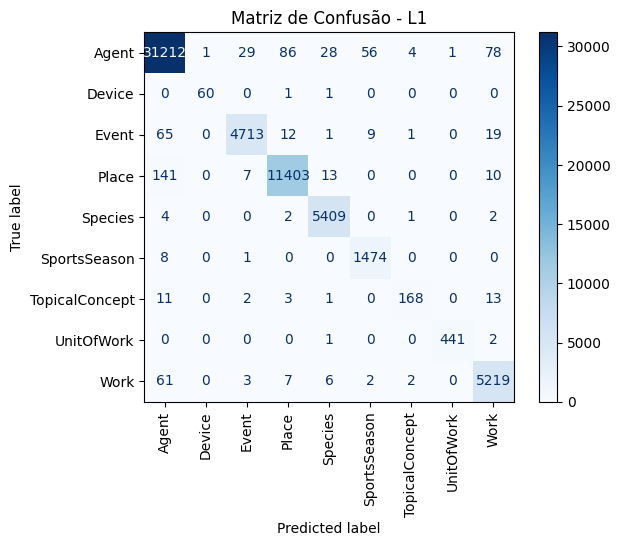

<Figure size 800x600 with 0 Axes>

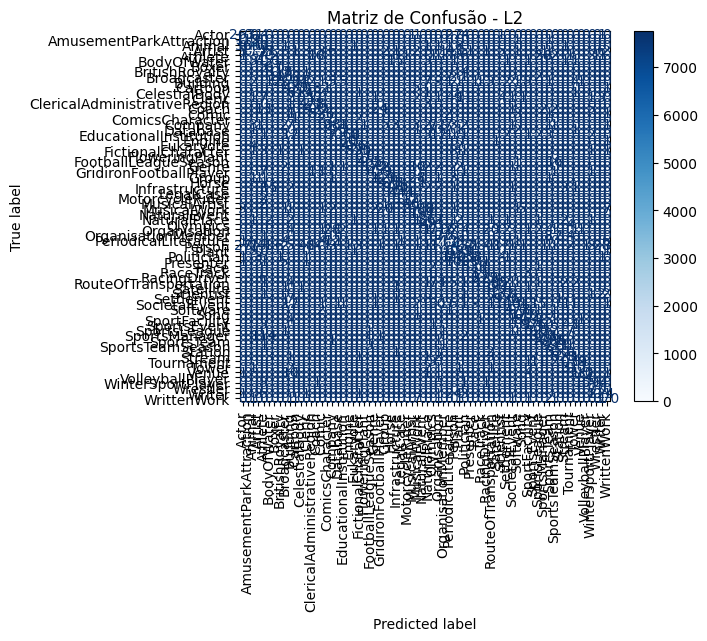

<Figure size 800x600 with 0 Axes>

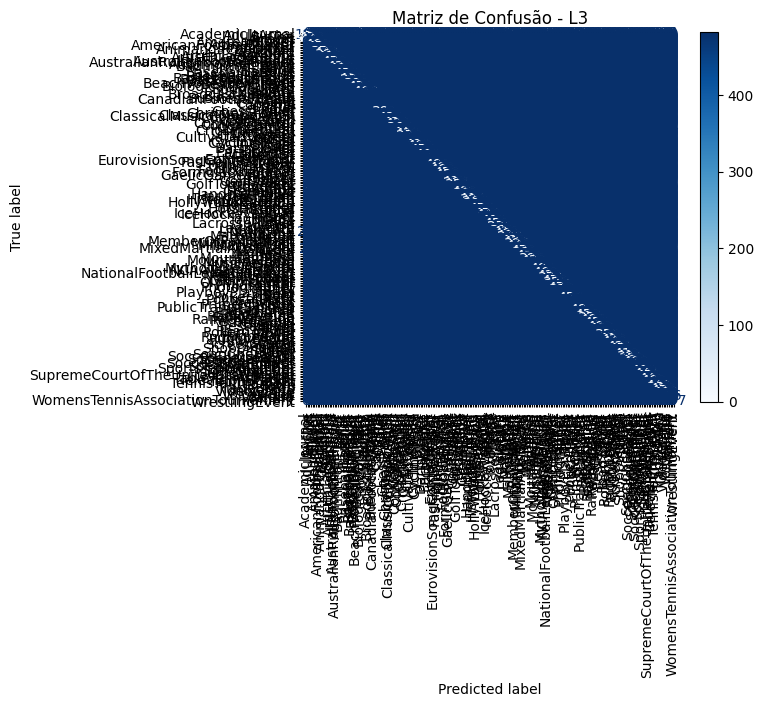

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Inicializa listas para os rótulos reais e previstos
true_labels_l1, true_labels_l2, true_labels_l3 = [], [], []
pred_labels_l1, pred_labels_l2, pred_labels_l3 = [], [], []

# Itera sobre o dataset de teste
for x, y in test_classifier_ds:
    preds = classifer_model.predict(x, verbose=0)  # preds = [pred_l1, pred_l2, pred_l3]

    # Extrai rótulos reais
    y_l1, y_l2, y_l3 = y["l1"].numpy(), y["l2"].numpy(), y["l3"].numpy()

    # Extrai rótulos previstos (argmax nas predições de cada saída)
    p_l1, p_l2, p_l3 = np.argmax(preds[0], axis=1), np.argmax(preds[1], axis=1), np.argmax(preds[2], axis=1)

    # Armazena
    true_labels_l1.extend(y_l1)
    true_labels_l2.extend(y_l2)
    true_labels_l3.extend(y_l3)

    pred_labels_l1.extend(p_l1)
    pred_labels_l2.extend(p_l2)
    pred_labels_l3.extend(p_l3)

<Figure size 800x600 with 0 Axes>

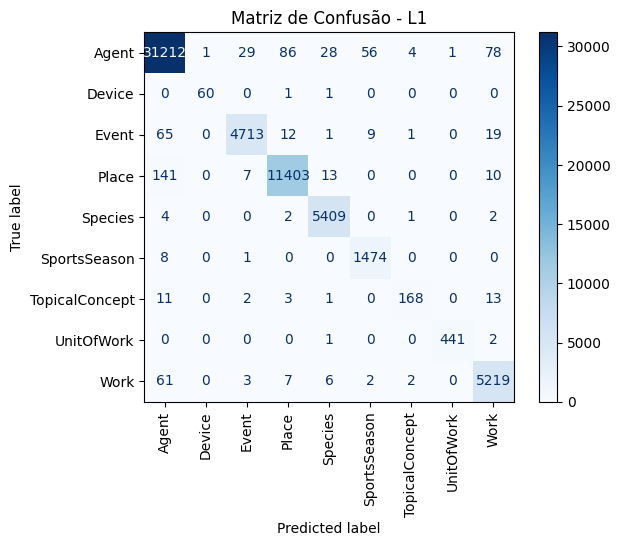

<Figure size 2000x1600 with 0 Axes>

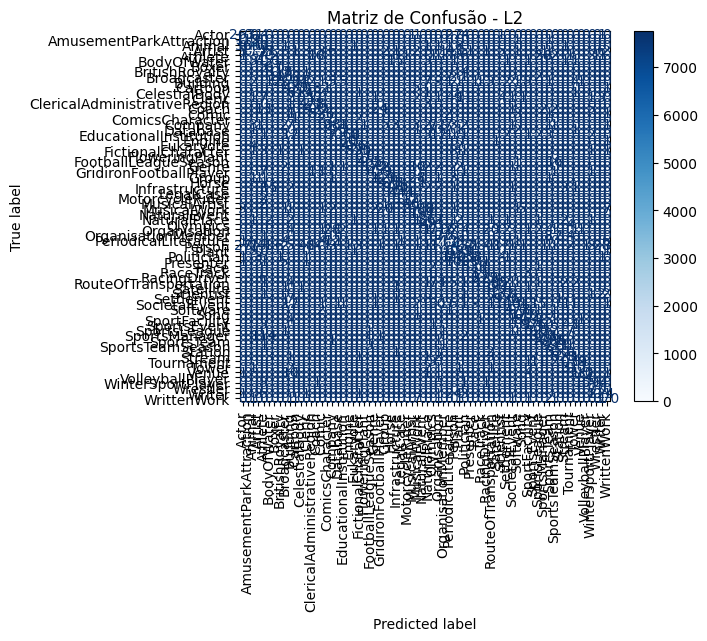

<Figure size 4800x3000 with 0 Axes>

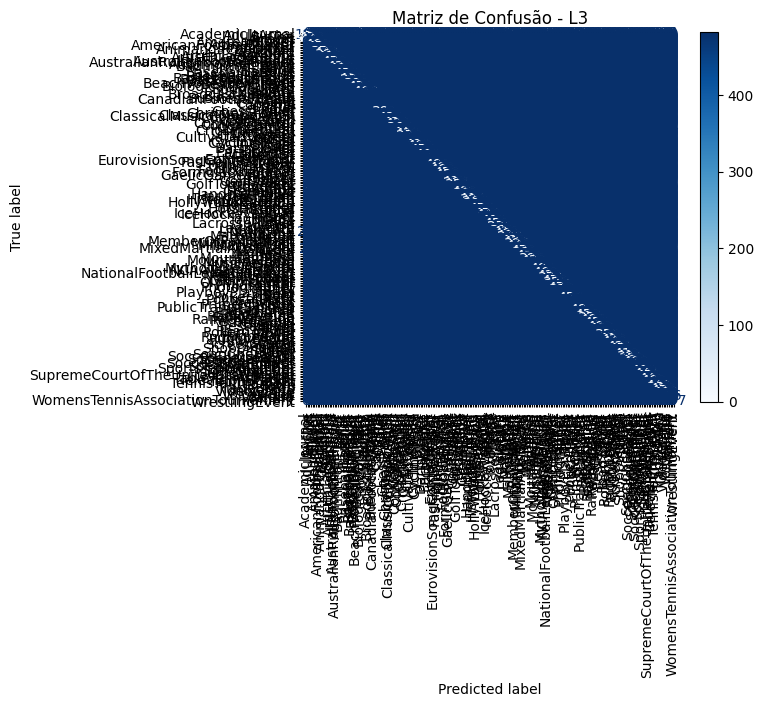

In [20]:
import os

# Função auxiliar pra plotar e salvar a matriz de confusão
def plot_confusion_matrix(true, pred, labels, title, figsize=(8, 6), save_path=None):
    cm = confusion_matrix(true, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=figsize)
    disp.plot(xticks_rotation="vertical", cmap="Blues", values_format='d')
    plt.title(title)
    plt.grid(False)
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

# Plota e salva para os três níveis
plot_confusion_matrix(
    true_labels_l1,
    pred_labels_l1,
    label_encoder_l1.classes_,
    "Matriz de Confusão - L1",
    figsize=(8, 6),
    save_path="confusion_matrices/l1_confusion_matrix.png"
)

plot_confusion_matrix(
    true_labels_l2,
    pred_labels_l2,
    label_encoder_l2.classes_,
    "Matriz de Confusão - L2",
    figsize=(20, 16),
    save_path="confusion_matrices/l2_confusion_matrix.png"
)

plot_confusion_matrix(
    true_labels_l3,
    pred_labels_l3,
    label_encoder_l3.classes_,
    "Matriz de Confusão - L3",
    figsize=(48, 30),
    save_path="confusion_matrices/l3_confusion_matrix.png"
)


In [21]:
from sklearn.metrics import classification_report

def generate_classification_report(true, pred, label_encoder, level_name, save_path=None):
    report = classification_report(true, pred, target_names=label_encoder.classes_, digits=4)
    print(f"\nRelatório de Classificação - {level_name}:\n")
    print(report)
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        with open(save_path, "w") as f:
            f.write(report)

# Gerar e salvar relatórios para os três níveis
generate_classification_report(
    true_labels_l1,
    pred_labels_l1,
    label_encoder_l1,
    "L1",
    save_path="classification_reports/l1_report.txt"
)

generate_classification_report(
    true_labels_l2,
    pred_labels_l2,
    label_encoder_l2,
    "L2",
    save_path="classification_reports/l2_report.txt"
)

generate_classification_report(
    true_labels_l3,
    pred_labels_l3,
    label_encoder_l3,
    "L3",
    save_path="classification_reports/l3_report.txt"
)



Relatório de Classificação - L1:

                precision    recall  f1-score   support

         Agent     0.9908    0.9910    0.9909     31495
        Device     0.9836    0.9677    0.9756        62
         Event     0.9912    0.9778    0.9844      4820
         Place     0.9904    0.9852    0.9878     11574
       Species     0.9907    0.9983    0.9945      5418
  SportsSeason     0.9565    0.9939    0.9749      1483
TopicalConcept     0.9545    0.8485    0.8984       198
    UnitOfWork     0.9977    0.9932    0.9955       444
          Work     0.9768    0.9847    0.9807      5300

      accuracy                         0.9886     60794
     macro avg     0.9814    0.9712    0.9759     60794
  weighted avg     0.9886    0.9886    0.9886     60794


Relatório de Classificação - L2:

                              precision    recall  f1-score   support

                       Actor     0.8651    0.8826    0.8738       298
     AmusementParkAttraction     1.0000    0.9835    0.991